# Interventions

Intervene on noise encodings and on latent causal variables and observe the effect on $x$

## Setup

In [1]:
import os

from omegaconf import OmegaConf
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

In [2]:
# disable autograd
torch.set_grad_enabled(False)

In [3]:
# experiment = "cubes"
# exp_name = "3node_fixed_seed"

# experiment = "scaling_cubes_nature"
# exp_name = "scaling_cubes_uniform_100k"

# experiment = "cubes_2d_complete"
experiment = "cubes_2d"
# experiment = "scaling_cubes_nature"

# exp_name = "saved/sbd_complete"
# exp_name = "saved/causal_variables_wrong_top?"
# exp_name = "cubes_2d_on_encoded_allow_collisions_large_child_noise"
# exp_name = "scaling_nature_cubes6dim_10k_uniform_1.0_child_noise"
exp_name = "cubes_2d_on_encoded_allow_collisions_equi_child_noise"
# exp_name = "scaling_nature_cubes6dim_10k_uniform"
# exp_name = "son_causal_variables_2dcubes_allow_collisions_25k_1.0_child_noise_scaling_config"
# exp_name = "cubes2d_on_true_causal_variables"
# exp_name = "son_causal_variables_2dcubes_allow_collisions_10k_0.5_child_noise_scaling_config"

# exp_name = "son_causal_variables_2dcubes_imbalanced_allow_collisions_10k_equi_child_noise"
# exp_name = "son_causal_variables_2dcubes_imbalanced_allow_collisions_25k_0.05_child_noise"
# exp_name = "son_causal_variables_2dcubes_allow_collisions_10k_0.05_child_noise"
# exp_name = "son_causal_variables_2dcubes_allow_collisions_10k_0_backup_2024-01-24_13:58:39"

# exp_name = "son_causal_variables_2dcubes_allow_collisions_25k_1.0_child_noise_scaling_config"


# NOISE_SCALE = 6.0
NOISE_SCALE = 4.0
# CHILD_NOISE_SCALE = 0.3
CHILD_NOISE_SCALE = 4.0
CHILD_VARIABLES = [5, 6]


base_dir = "/mnt/raid/ni/jonasb/wscrl"

In [4]:
model_path = os.path.join(base_dir, exp_name, "models", "model.pt")
cfg_path = os.path.join(base_dir, exp_name, "config.yml")
metrics_path = os.path.join(base_dir, exp_name, "metrics", "test_metrics.csv")

In [5]:
cfg = OmegaConf.load(cfg_path)
cfg.data.always_generate_new_data = False

In [10]:
dim_z = cfg.model.dim_z
dim_x = cfg.data.dim_x

In [7]:
batchsize = 64
if experiment == "cubes":
    from experiments.cubes import create_model, get_dataloader

    data_type = "image"
    model = create_model(cfg)
    train_loader = get_dataloader(cfg, "train", batchsize=batchsize, shuffle=True)
    val_loader = get_dataloader(cfg, "val", batchsize=batchsize, shuffle=False)
if experiment == "scaling_cubes_nature":
    from experiments.scaling_cubes import create_model, load_dataset

    data_type = "low_dim"
    x_dim = 3
    model = create_model(cfg)
    train_data = load_dataset(cfg, "train", normalize=cfg.data.normalize)
    val_data = load_dataset(cfg, "val", normalize=cfg.data.normalize)
    train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batchsize, shuffle=False)
if experiment == "cubes_2d_complete":
    from experiments.cubes_2d_complete import create_model, get_dataloader

    data_type = "image"
    model = create_model(cfg)
    train_loader = get_dataloader(
        cfg, "train", batchsize=batchsize, shuffle=True, include_noise_encodings=True
    )
    val_loader = get_dataloader(
        cfg, "val", batchsize=batchsize, shuffle=False, include_noise_encodings=True
    )
if experiment == "cubes_2d":
    from experiments.cubes_2d import create_model, get_dataloader

    data_type = "encoding"
    model = create_model(cfg)
    train_loader = get_dataloader(
        cfg, "train", batchsize=batchsize, shuffle=True, include_noise_encodings=True
    )
    val_loader = get_dataloader(
        cfg, "val", batchsize=batchsize, shuffle=False, include_noise_encodings=True
    )

model.load_state_dict(torch.load(model_path))
model.eval()

device = torch.device(cfg.training.device)
model.to(device)

/mnt/antares_raid/home/jonasb/mambaforge/envs/wscrl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/antares_raid/home/jonasb/Projects/wscrl/repo/experiments/cubes_2d.py:50: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(


ILCM(
  (scm): MLPImplicitSCM(
    (solution_functions): ModuleList(
      (0-5): 6 x ConditionalAffineScalarTransform(
        (param_net): Sequential(
          (0): Linear(in_features=12, out_features=100, bias=True)
          (1): ReLU()
          (2): Linear(in_features=100, out_features=100, bias=True)
          (3): ReLU()
          (4): Linear(in_features=100, out_features=2, bias=True)
        )
      )
    )
    (base_density): StandardNormal()
  )
  (intervention_prior): InterventionPrior()
  (encoder): GaussianEncoder(
    (net): Sequential(
      (0): Linear(in_features=16, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): ReLU()
      (8): Linear(in_features=64, out_features=64, bias=True)
      (9): ReLU()
    )
    (mean_head): Linear(in_feature

In [8]:
if experiment == "cubes_2d":

    def noise_encodings_from_causal_variables(
        causal_variables,
        noise_scale=NOISE_SCALE,
        noise_scale_children=CHILD_NOISE_SCALE,
        weight_1=1.0,
        weight_2=0.7,
    ):
        noise_encodings = torch.zeros((len(causal_variables), dim_z))

        noise_encodings[:, 0] = causal_variables[:, 0] / noise_scale
        noise_encodings[:, 1] = causal_variables[:, 1] / noise_scale
        noise_encodings[:, 2] = causal_variables[:, 2] / noise_scale
        noise_encodings[:, 3] = causal_variables[:, 3] / noise_scale

        mean_position_x = (
            causal_variables[:, 0] * weight_1 + causal_variables[:, 2] * weight_2
        ) / (weight_1 + weight_2)
        mean_position_y = (
            causal_variables[:, 1] * weight_1 + causal_variables[:, 3] * weight_2
        ) / (weight_1 + weight_2)
        noise_encodings[:, 4] = (causal_variables[:, 4] - mean_position_x) / noise_scale_children
        noise_encodings[:, 5] = (causal_variables[:, 5] - mean_position_y) / noise_scale_children

        return noise_encodings

In [163]:
# TODO: refactor this!
if data_type == "encoding":
    # Add "/mnt/antares_raid/home/jonasb/Projects/spatialvaes" to PYTHONPATH
    import sys

    sys.path.append("/mnt/antares_raid/home/jonasb/Projects/spatialvaes")

    from pathlib import Path
    import json
    from train_vae import create_model as create_vae_model
    from spatialvaes.vaes import ImageVAE, SpatialBroadcastVAE

    VAE_EXPERIMENT_PATH = Path(
        "/mnt/antares_raid/home/jonasb/Projects/spatialvaes/logs/SpatialBroadcastVAE/2dcubes_grayscale_shapes_scale_1.0_equi_child_noise_allow_collisions_25k_blackbg/0"
    )
    VAE_STATE_DICT_PATH = VAE_EXPERIMENT_PATH / "epoch_399.pt"
    VAE_CONFIG_PATH = VAE_EXPERIMENT_PATH / "config.json"

    with open(VAE_CONFIG_PATH) as f:
        conf = json.load(f)

    vae = create_vae_model(conf)
    vae.load_state_dict(torch.load(VAE_STATE_DICT_PATH))
    vae.to(device)

    decoder = vae.decoder

in_dim: 1024


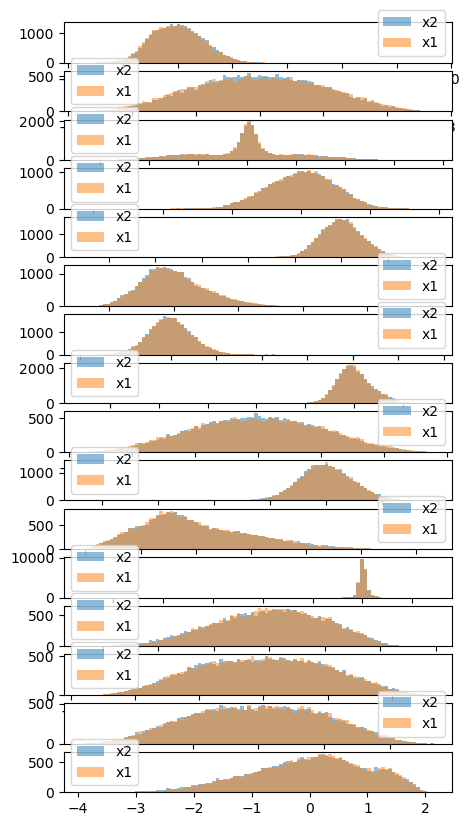

In [13]:
def plot_x_dims(dim_x, loader):
    fig, axes = plt.subplots(nrows=dim_x, figsize=(5, 10))
    x1_list = []
    x2_list = []

    for i, batch in enumerate(loader):
        print(f"Batch {i + 1} / {len(loader)}", end="\r")
        x1, x2, *_ = batch

        x1, x2 = (
            x1.to(device),
            x2.to(device),
        )

        x1_list.append(x1.cpu().numpy())
        x2_list.append(x2.cpu().numpy())

    x1 = np.concatenate(x1_list)
    x2 = np.concatenate(x2_list)

    for dim in range(dim_x):
        ax = axes[dim]
        _, bins, _ = ax.hist(x2[:, dim], bins=100, alpha=0.5, label="x2")
        ax.hist(x1[:, dim], bins=bins, alpha=0.5, label="x1")
        ax.legend()
    return fig, ax

if data_type == "encoding" or data_type == "low_dim":
    plot_x_dims(dim_x, val_loader)

In [164]:
len(train_loader.dataset)

25000

In [165]:
from notebooks.util import (
    calculate_intervention_posteriors,
    calculate_intervention_posterior_heatmap,
)

intervention_posteriors_val, intervention_labels_val = calculate_intervention_posteriors(
    model, val_loader, device=device
)
heatmap_val = calculate_intervention_posterior_heatmap(
    intervention_posteriors_val, intervention_labels_val, dim_z, device=device
)
# Maximal a posteriori intervention for each intervention label
_, MAP_interventions = heatmap_val.max(dim=1)
print(f"{MAP_interventions=}")

Batch 16 / 16
MAP_interventions=tensor([0, 6, 4, 5, 3, 1, 2], device='cuda:1')


## Disentanglement

In [11]:
metrics = np.loadtxt(metrics_path, delimiter=",", skiprows=1)
metrics_names = np.loadtxt(metrics_path, delimiter=",", max_rows=1, dtype=str)

metrics = {name: metric for name, metric in zip(metrics_names, metrics)}
# metrics

In [12]:
def generate_directed_graph_matrix(edge_dict, target_prefix):
    """
    Utility function to generate a directed graph matrix from a dictionary of edges.
    """
    # Get the keys with the target prefix
    keys_with_prefix = [key for key in edge_dict if key.startswith(target_prefix)]
    # Extract the i and j values from the keys
    indices = [
        (int(key[len(target_prefix) :].split("_")[0]), int(key[len(target_prefix) :].split("_")[1]))
        for key in keys_with_prefix
    ]

    # Determine the size of the matrix
    matrix_size = max(max(indices, key=lambda x: max(x))) + 1

    # Initialize an empty tensor and populate it based on the dictionary keys with the target prefix
    graph_tensor = torch.zeros(matrix_size, matrix_size)

    for key in keys_with_prefix:
        i, j = map(int, key[len(target_prefix) :].split("_"))
        graph_tensor[i, j] = edge_dict[key]

    return graph_tensor

In [13]:
# metrics_causal_importance_matrix = {
#     k: v for k, v in metrics.items() if "causal_importance_matrix" in k
# }

# causal_importance_matrix = np.zeros((dim_z, dim_z))

# for k, v in metrics_causal_importance_matrix.items():
#     i, j = k.split("_")[-2:]
#     i, j = int(i), int(j)
#     causal_importance_matrix[i, j] = v
# causal_importance_matrix
causal_importance_matrix = generate_directed_graph_matrix(metrics, "causal_importance_matrix_")
if "noise_importance_matrix_0_0" in metrics.keys():
    noise_importance_matrix = generate_directed_graph_matrix(metrics, "noise_importance_matrix_")

In [14]:
def plot_importance_matrix(importance_matrix, variable_type: str):
    fig, ax = plt.subplots()
    img = ax.imshow(importance_matrix)

    ax.set_xlabel("True")
    ax.set_ylabel("Model")
    ax.set_title(f"{variable_type.title()} Importance Matrix")
    ax.set_xticks(np.arange(dim_z))
    ax.set_yticks(np.arange(dim_z))
    ax.set_xticklabels(np.arange(dim_z))
    ax.set_yticklabels(np.arange(dim_z))
    cbar = ax.figure.colorbar(img, ax=ax)

    fig.tight_layout()

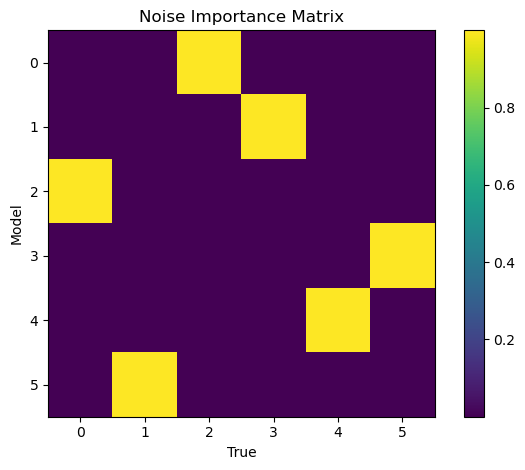

In [39]:
plot_importance_matrix(noise_importance_matrix, variable_type="noise")

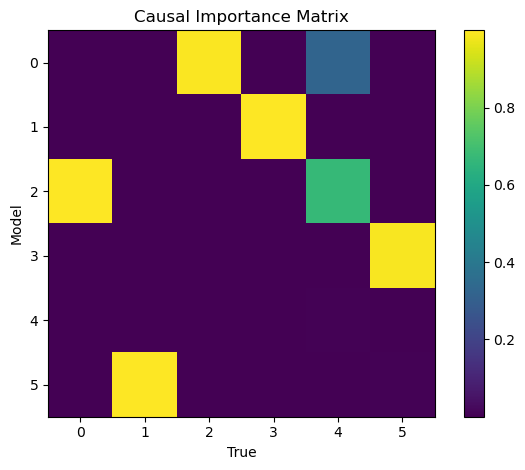

In [40]:
plot_importance_matrix(causal_importance_matrix, variable_type="causal")

In [41]:
from notebooks.util import (
    calculate_intervention_posteriors,
    calculate_intervention_posterior_heatmap,
)

intervention_posteriors_val, intervention_labels_val = calculate_intervention_posteriors(
    model, val_loader, device=device
)
heatmap_val = calculate_intervention_posterior_heatmap(
    intervention_posteriors_val, intervention_labels_val, dim_z, device=device
)
# Maximal a posteriori intervention for each intervention label
_, MAP_interventions = heatmap_val.max(dim=1)
print(f"{MAP_interventions=}")

Batch 16 / 16
MAP_interventions=tensor([0, 3, 6, 1, 2, 5, 4], device='cuda:1')


## Noise encoding distribution

In [56]:
def plot_noise_encoding_distributions(model, loader, dim, only_intervened=False):
    fig, ax = plt.subplots(figsize=(10, 5))
    e1_hat_list = []
    e2_hat_list = []

    for i, batch in enumerate(loader):
        print(f"Batch {i + 1} / {len(loader)}", end="\r")
        if experiment == "cubes":
            x1, x2, z1, z2, intervention_labels, e1, e2 = batch
        elif experiment == "scaling_cubes_nature":
            raise Exception("No noise encodings available")
        elif experiment == "cubes_2d_complete":
            x1, x2, z1, z2, intervention_labels, interventions, e1, e2 = batch
        elif experiment == "cubes_2d":
            x1, x2, z1, z2, intervention_labels, interventions, e1, e2 = batch

        x1, x2 = (
            x1.to(device),
            x2.to(device),
        )

        e1_hat = model.encode_to_noise(x1)
        e2_hat = model.encode_to_noise(x2)

        if only_intervened:
            e1_hat = e1_hat[intervention_labels == dim + 1]
            e2_hat = e2_hat[intervention_labels == dim + 1]

        e1_hat_list.append(e1_hat.cpu().numpy())
        e2_hat_list.append(e2_hat.cpu().numpy())
    e1_hat = np.concatenate(e1_hat_list)
    e2_hat = np.concatenate(e2_hat_list)

    _, bins, _ = ax.hist(e2_hat[:, dim], bins=100, alpha=0.5, label="e2_hat")
    ax.hist(e1_hat[:, dim], bins=bins, alpha=0.5, label="e1_hat")
    ax.legend()
    return fig, ax

Batch 16 / 16
(1000, 6)
(1000, 6)


(<Figure size 1000x500 with 1 Axes>, <Axes: >)

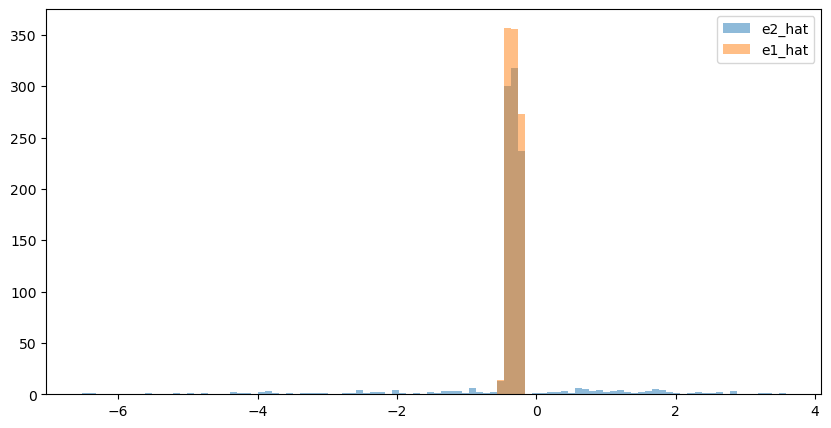

In [57]:
plot_noise_encoding_distributions(model, val_loader, dim=4)

Batch 16 / 16
(143, 6)
(143, 6)


(<Figure size 1000x500 with 1 Axes>, <Axes: >)

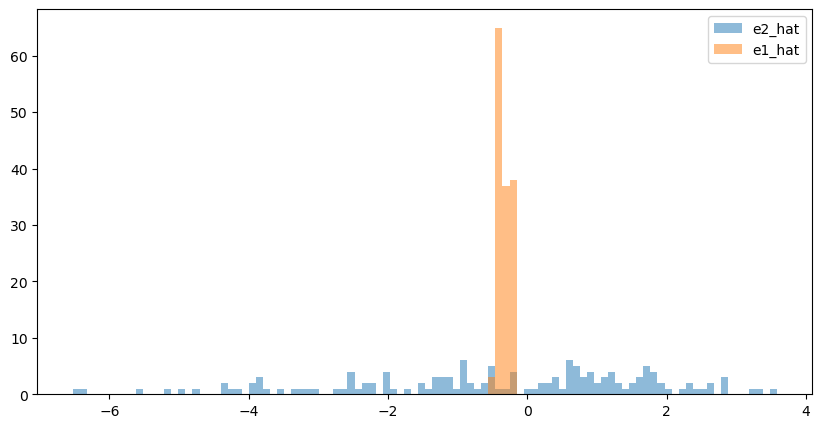

In [58]:
plot_noise_encoding_distributions(model, val_loader, dim=4, only_intervened=True)

In [34]:
# Calculate noise encodings from causal variables


def calculate_noise_encodings(loader):
    e1_list = []
    e2_list = []
    intervention_labels_list = []
    for i, batch in enumerate(loader):
        print(f"Batch {i + 1} / {len(loader)}", end="\r")
        if experiment == "cubes":
            x1, x2, z1, z2, intervention_labels, e1, e2 = batch
        elif experiment == "scaling_cubes_nature":
            raise Exception("No noise encodings available")
        elif experiment == "cubes_2d_complete":
            x1, x2, z1, z2, intervention_labels, interventions, e1, e2 = batch
        elif experiment == "cubes_2d":
            x1, x2, z1, z2, intervention_labels, interventions, e1, e2 = batch

        z1, z2, intervention_labels = (
            z1.to(device),
            z2.to(device),
            intervention_labels.to(device),
        )

        e1 = noise_encodings_from_causal_variables(z1, noise_scale=6.0, noise_scale_children=0.3)
        e2 = noise_encodings_from_causal_variables(z2, noise_scale=6.0, noise_scale_children=0.3)

        e1_list.append(e1.cpu().numpy())
        e2_list.append(e2.cpu().numpy())
        intervention_labels_list.append(intervention_labels.cpu().numpy())

    e1 = np.concatenate(e1_list)
    e2 = np.concatenate(e2_list)
    intervention_labels = np.concatenate(intervention_labels_list)

    return e1, e2, intervention_labels


e1, e2, intervention_labels = calculate_noise_encodings(val_loader)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 37., 30., 61., 15.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([-31.69568253, -31.0586586 , -30.42163658, -29.78461266,
        -29.14758873, -28.5105648 , -27.87354279, -27.23651886,
        -26.59949493, -25.96247292, -25.32544899, -24.68842506,
        -24.05140114, -23.41437912, -22.77735519, -22.14033127,
        -21.50330734, -20.86628532, -20.2292614 , -19.59223747,
        -18.95521545, -18.31819153, -17.6811676 , -17.04414368,
        -16.40712166, -15.77009773, -15.13307476, 

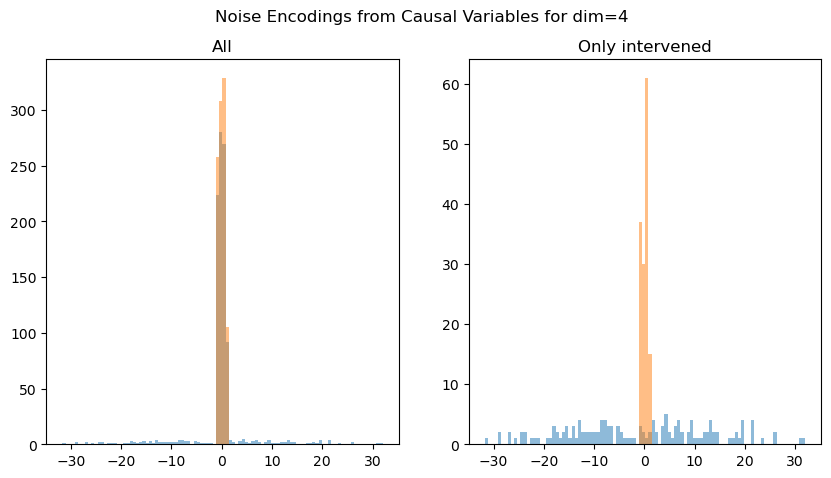

In [36]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))


dim = 4

fig.suptitle(f"Noise Encodings from Causal Variables for dim={dim}")

ax = axes[0]
ax.set_title("All")
_, bins, _ = ax.hist(e2[:, dim], bins=100, alpha=0.5, label="e2_hat")
ax.hist(e1[:, dim], bins=bins, alpha=0.5, label="e1_hat")

ax = axes[1]
ax.set_title("Only intervened")
_, bins, _ = ax.hist(e2[intervention_labels == dim + 1, dim], bins=100, alpha=0.5, label="e2_hat")
ax.hist(e1[intervention_labels == dim + 1, dim], bins=bins, alpha=0.5, label="e1_hat")

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,  61., 210., 193., 196., 197., 143.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]),
 array([-5.98720965, -5.86799282, -5.74877599, -5.62955916, -5.51034234,
        -5.39112551, -5.27190868, -5.15269185, -5.03347503, -4.9142582 ,
        -4.79504137, -4.67582455, -4.55660772, -4.43739089, -4.31817406,
        -4.19895724, -4.07974041, -3.96052358, -3.84130675, -3.72208993,
        -3.6028731 , -3.48

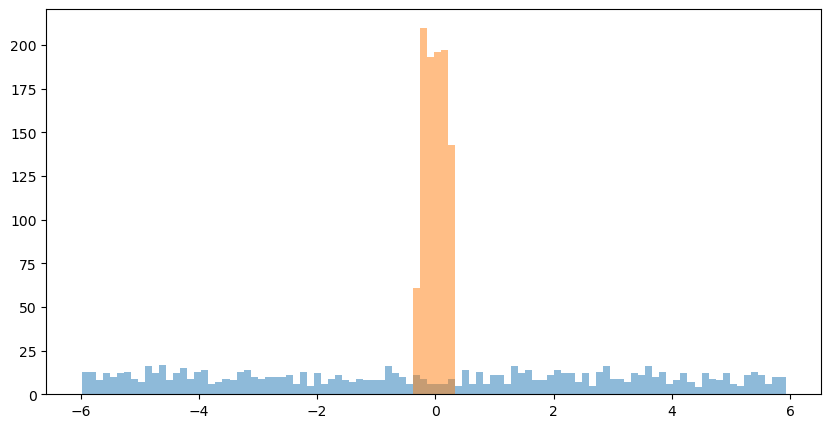

In [9]:
e1_true = np.random.uniform(-0.3, 0.3, 1000)
e2_true = np.random.uniform(-6, 6, 1000)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

ax = axes[0]
_, bins, _ = ax.hist(e2_true, bins=100, alpha=0.5, label="e2_true")
ax.hist(e1_true, bins=bins, alpha=0.5, label="e1_true")

plt.legend()

## Plot latent space

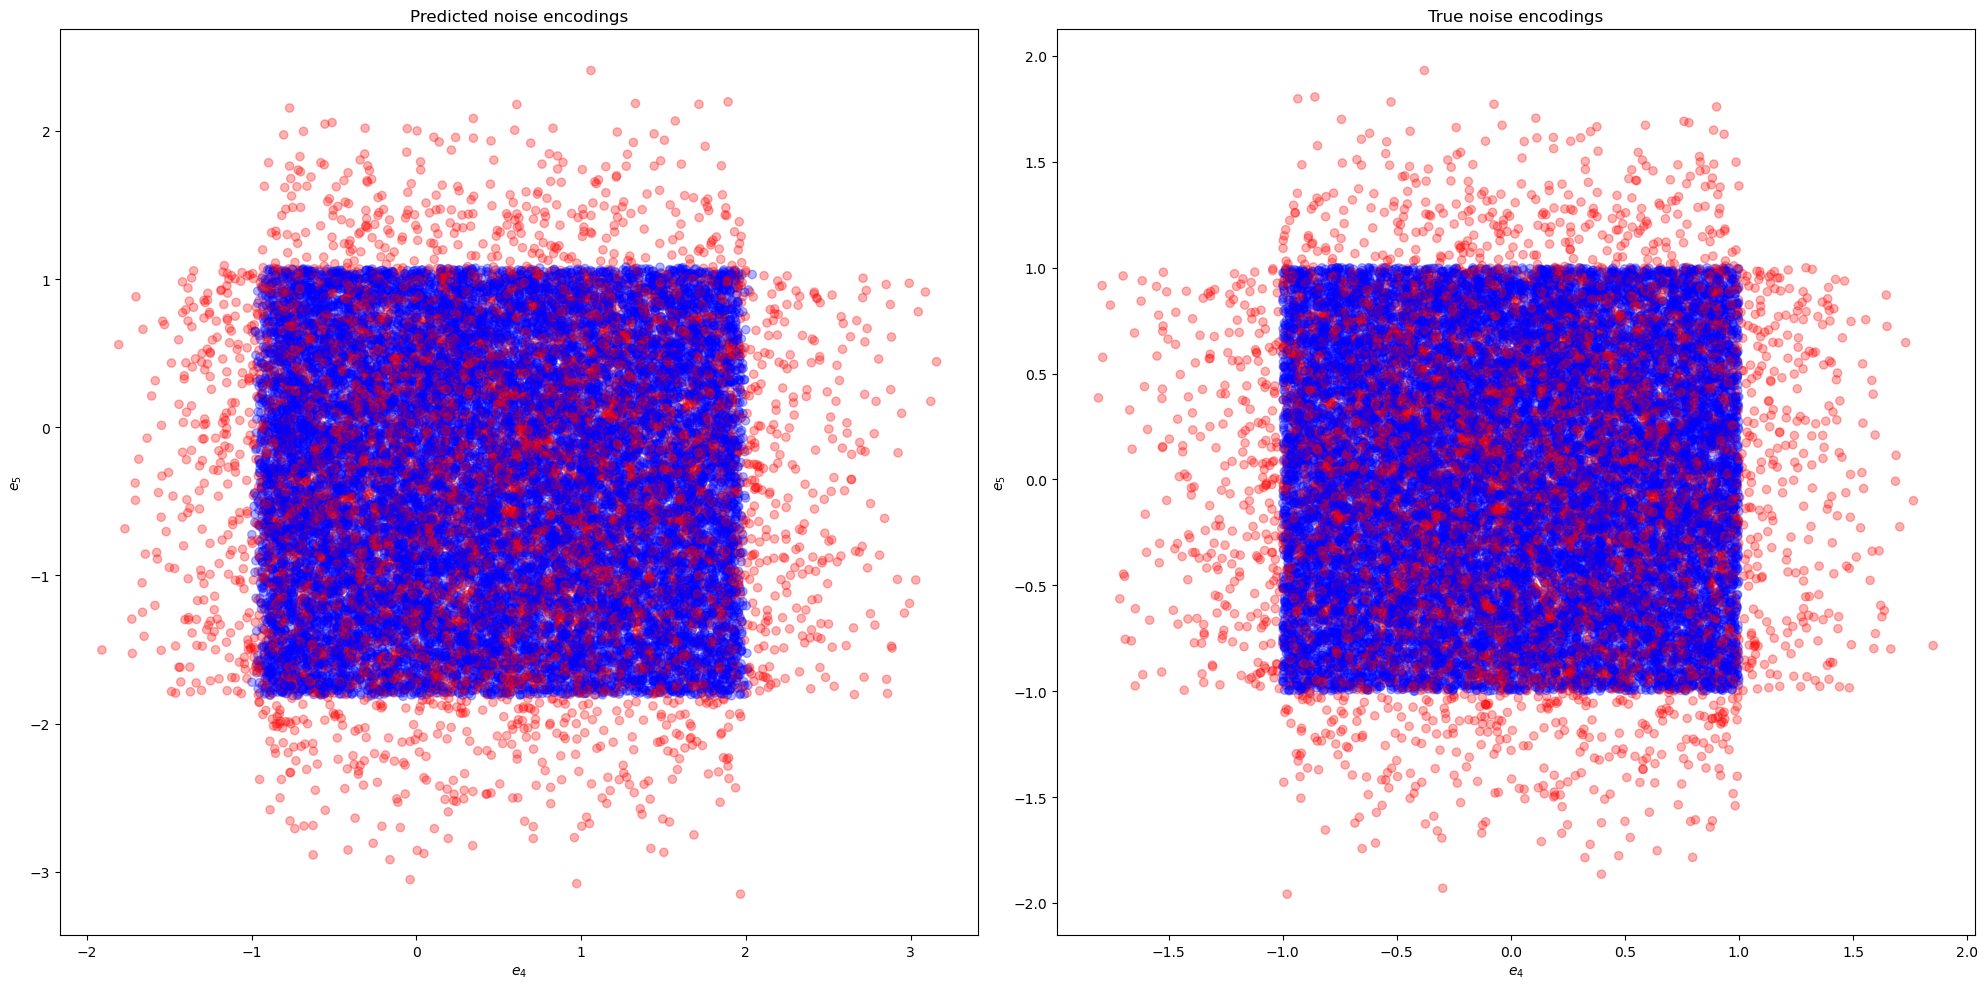

In [167]:
def plot_latent_space(model, loader, dims=[4, 5], num_batches=2, only_strong_interventions=False):
    fig, axes = plt.subplots(ncols=2, figsize=(20, 10))

    axes[0].set_title("Predicted noise encodings")
    axes[1].set_title("True noise encodings")

    for ax in axes:
        ax.set_xlabel(f"$e_{dims[0]}$")
        ax.set_ylabel(f"$e_{dims[1]}$")

    if num_batches is None:
        num_batches = len(loader)

    for i, batch in enumerate(loader):
        print(f"Batch {i + 1} / {num_batches}", end="\r")
        if experiment == "cubes":
            x1, x2, z1, z2, intervention_labels, e1, e2 = batch
        elif experiment == "scaling_cubes_nature":
            raise Exception("No noise encodings available")
        elif experiment == "cubes_2d_complete":
            x1, x2, z1, z2, intervention_labels, interventions, e1, e2 = batch
        elif experiment == "cubes_2d":
            x1, x2, z1, z2, intervention_labels, interventions, e1, e2 = batch

        x1, x2 = x1.to(device), x2.to(device)
        intervention_labels = intervention_labels.to(device)
        e1_mean, e1_std = model.encoder.mean_std(x1)
        e2_mean, e2_std = model.encoder.mean_std(x2)

        intervened = torch.zeros_like(intervention_labels)
        for dim in dims:
            dim_intervened = intervention_labels == dim + 1
            intervened[dim_intervened] = 1

        intervened = intervened.squeeze()

        colors = np.where(intervened.cpu().numpy() == 1, "red", "blue")

        # eps1 = noise_encodings_from_causal_variables(z1)
        eps2 = noise_encodings_from_causal_variables(z2)
        if only_strong_interventions:
            selected = torch.zeros_like(intervention_labels.squeeze()).cpu()
            # strong_interventions1 = torch.abs(eps1) > 1.0
            strong_interventions2 = torch.abs(eps2) > 1.0

            for dim in dims:
                # selected = selected | strong_interventions1[:, dim]
                selected = selected | strong_interventions2[:, dim]
        else:
            selected = torch.ones_like(intervention_labels.squeeze()).cpu()

        selected = selected.bool().cpu().numpy()

        e1_mean, e2_mean, e1_std, e2_std = (
            e1_mean.cpu().numpy(),
            e2_mean.cpu().numpy(),
            e1_std.cpu().numpy(),
            e2_std.cpu().numpy(),
        )

        corresponding_dims = [MAP_interventions[dim + 1] - 1 for dim in dims]
        ax = axes[0]
        # ax.scatter(e1_mean[:, corresponding_dims[0]], e1_mean[:, corresponding_dims[1]], c="b")
        ax.scatter(
            e2_mean[selected, corresponding_dims[0]],
            e2_mean[selected, corresponding_dims[1]],
            c=colors[selected],
            alpha=0.3,
        )

        ax = axes[1]
        ax.scatter(eps2[selected, dims[0]], eps2[selected, dims[1]], c=colors[selected], alpha=0.3)
        if i == num_batches - 1:
            break
    fig.tight_layout()


plot_latent_space(
    model, train_loader, dims=[4, 5], num_batches=None, only_strong_interventions=False
)

In [44]:
MAP_interventions

tensor([0, 3, 1, 6, 4, 2, 5], device='cuda:1')

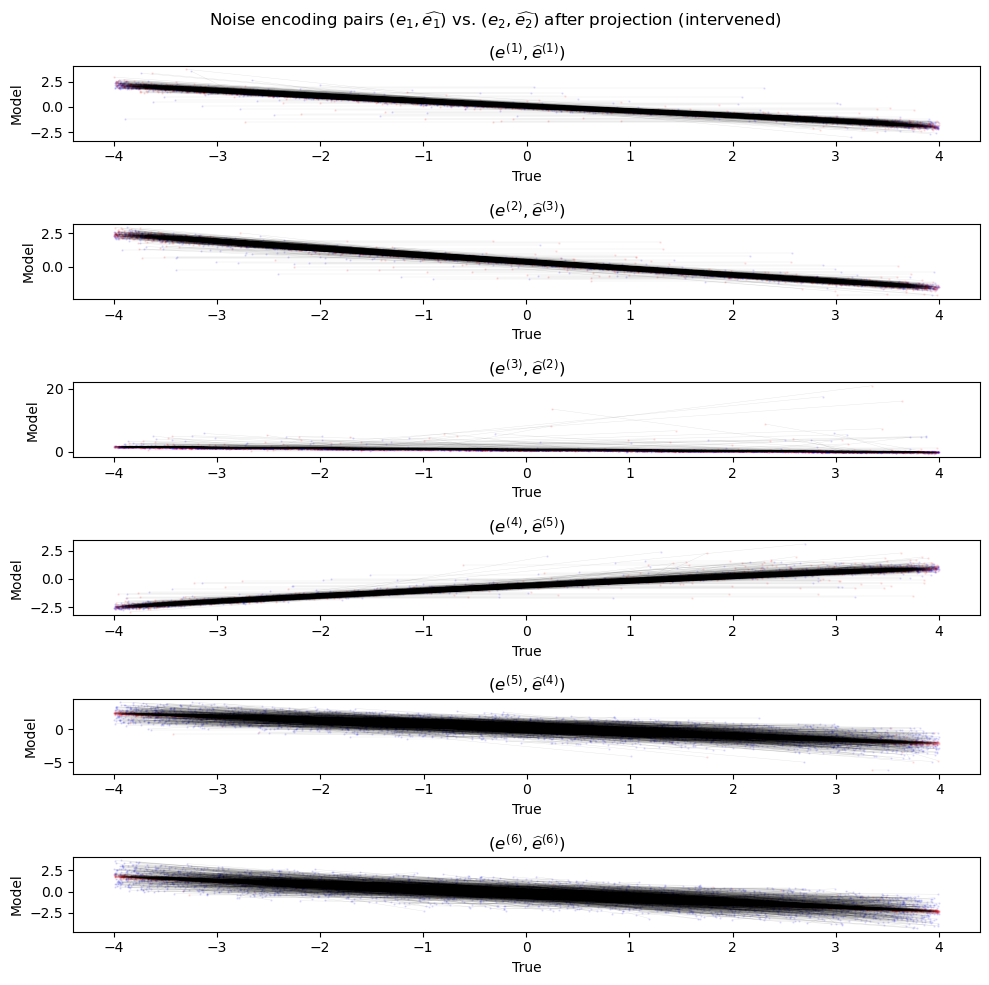

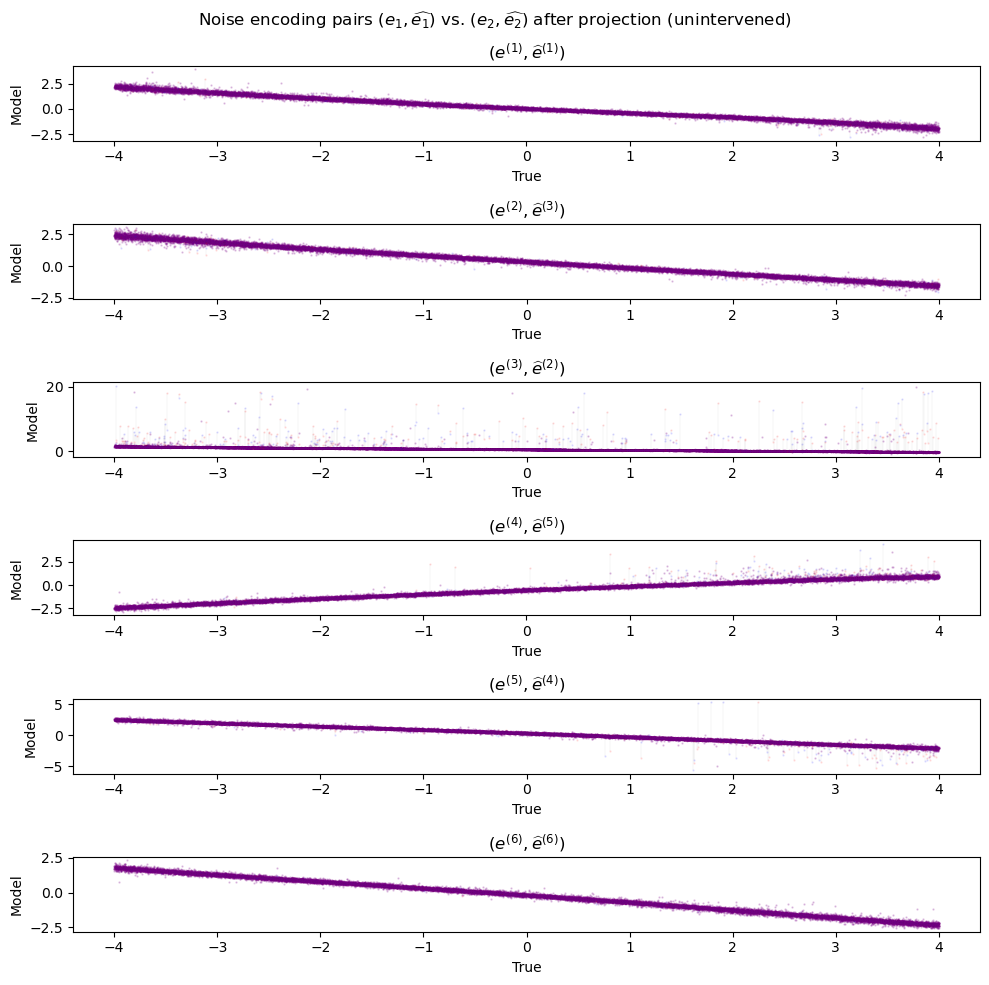

In [94]:
from matplotlib.collections import LineCollection


def plot_noise_pairs(
    model,
    loader,
    MAP_interventions,
    dim_z,
    device,
    after_proj=False,
    intervention_type="intervened",
    axes=None,
    child_variables=CHILD_VARIABLES,
    noise_scale=NOISE_SCALE,
    child_noise_scale=CHILD_NOISE_SCALE,
):
    assert intervention_type in ["intervened", "unintervened", "all"]
    # remove empty intervention because it does not have a corresponding dimension in the latent space
    MAP_interventions = MAP_interventions[1:] - 1

    fig, axes = plt.subplots(
        nrows=dim_z,
        figsize=(10, 10),
        # sharex=True, sharey=True
    )

    title = "Noise encoding pairs $(e_1, \widehat{e_1})$ vs. $(e_2, \widehat{e_2})$"
    if after_proj:
        title += " after projection"
    title += f" ({intervention_type})"
    fig.suptitle(title)

    for dim, ax in enumerate(axes):
        ax.set_title(f"$(e^{{({dim+1})}}, \widehat{{e}}^{{({MAP_interventions[dim] + 1})}})$")
        ax.set_xlabel("True")
        ax.set_ylabel("Model")

    for batch in loader:
        if experiment == "cubes":
            x1, x2, z1, z2, intervention_labels, e1, e2 = batch
        elif experiment == "scaling_cubes_nature":
            raise Exception("No noise encodings available")
        elif experiment == "cubes_2d_complete":
            x1, x2, z1, z2, intervention_labels, interventions, e1, e2 = batch
        elif experiment == "cubes_2d":
            x1, x2, z1, z2, intervention_labels, interventions, e1, e2 = batch

        x1, x2, z1, z2, e1, e2, intervention_labels = (
            x1.to(device),
            x2.to(device),
            z1.to(device),
            z2.to(device),
            e1.to(device),
            e2.to(device),
            intervention_labels.to(device),
        )

        (
            x1_reco,
            x2_reco,
            e1_mean,
            e2_mean,
            e1_proj,
            e2_proj,
            intervention_posterior,
            most_likely_intervention_idx,
            intervention,
        ) = model.encode_decode_pair(x1, x2)

        e1, e2 = e1.cpu().numpy(), e2.cpu().numpy()
        e1_mean, e2_mean = e1_mean.cpu().numpy(), e2_mean.cpu().numpy()
        e1_proj, e2_proj = e1_proj.cpu().numpy(), e2_proj.cpu().numpy()
        intervention_labels = intervention_labels.squeeze().cpu().numpy()

        for dim in range(dim_z):
            ax = axes[dim]
            MAP_dim = MAP_interventions[dim]

            if after_proj:
                e1_hat = e1_proj
                e2_hat = e2_proj
            else:
                e1_hat = e1_mean
                e2_hat = e2_mean

            e1_dim = e1[:, dim]
            e2_dim = e2[:, dim]
            e1_hat_dim = e1_hat[:, MAP_dim]
            e2_hat_dim = e2_hat[:, MAP_dim]

            # child variables
            if dim + 1 in child_variables:
                noise_scale_observational = child_noise_scale
                noise_scale_counterfactual = np.where(
                    intervention_labels == dim + 1, noise_scale, child_noise_scale
                )
            else:
                noise_scale_observational = noise_scale
                noise_scale_counterfactual = noise_scale

            e1_dim = e1_dim * noise_scale_observational
            e2_dim = e2_dim * noise_scale_counterfactual

            if intervention_type == "intervened":
                e1_dim = e1_dim[intervention_labels == dim + 1]
                e2_dim = e2_dim[intervention_labels == dim + 1]
                e1_hat_dim = e1_hat_dim[intervention_labels == dim + 1]
                e2_hat_dim = e2_hat_dim[intervention_labels == dim + 1]
            elif intervention_type == "unintervened":
                e1_dim = e1_dim[intervention_labels != dim + 1]
                e2_dim = e2_dim[intervention_labels != dim + 1]
                e1_hat_dim = e1_hat_dim[intervention_labels != dim + 1]
                e2_hat_dim = e2_hat_dim[intervention_labels != dim + 1]

            if dim_z + 1 == 5 or dim_z + 1 == 6 and intervention_labels == dim + 1:
                pass

            lines = [
                [(_e1, _e1_hat), (_e2, _e2_hat)]
                for _e1, _e1_hat, _e2, _e2_hat in zip(e1_dim, e1_hat_dim, e2_dim, e2_hat_dim)
            ]

            lc = LineCollection(lines, colors="black", linewidths=0.3, alpha=0.1)
            ax.add_collection(lc)

            ax.scatter(e1_dim, e1_hat_dim, s=0.5, label="Observational", color="red", alpha=0.1)
            ax.scatter(e2_dim, e2_hat_dim, s=0.5, label="Counterfactual", color="blue", alpha=0.1)

    fig.tight_layout()


plot_noise_pairs(
    model,
    val_loader,
    MAP_interventions,
    dim_z,
    device,
    after_proj=True,
    intervention_type="intervened",
)
plt.show()
plot_noise_pairs(
    model,
    val_loader,
    MAP_interventions,
    dim_z,
    device,
    after_proj=True,
    intervention_type="unintervened",
)
plt.show()

## Plot data and reconstructions

In [11]:
from matplotlib.ticker import MaxNLocator


def unnormalize(cfg, x):
    if cfg.preprocessing.normalization.type == "minmax":
        x = x * (
            torch.FloatTensor(cfg.data.x_max).view(3, 1, 1)
            - torch.FloatTensor(cfg.data.x_min).view(3, 1, 1)
        ) + torch.FloatTensor(cfg.data.x_min).view(3, 1, 1)
    else:
        raise NotImplementedError
    return x


def plot_x(ax, x, opacity=1):
    if data_type == "image":
        # ax.imshow(x.permute(1, 2, 0).clamp(0, 255).to(torch.uint8))
        ax.imshow(x.permute(1, 2, 0))
        ax.axis("off")
    elif data_type == "low_dim":
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.scatter(x=range(1, x_dim + 1), y=x, marker="s", color="black", s=100, alpha=opacity)
    elif data_type == "encoding":
        x = x.to(device)
        x_decoded = decoder(x.view(1, x.size(0), 1, 1))
        ax.imshow(x_decoded[0].cpu().permute(1, 2, 0))
        ax.axis("off")


def plot_x_states(ax, xs, opacities):
    if data_type == "low_dim":
        for x, opacity in zip(xs, opacities):
            plot_x(ax, x, opacity=opacity)
    else:
        plot_x(ax, xs[0])


def plot_rows(xs, col_labels=None, nrows=4, x_states=None, opacities=None):
    ncols = len(xs)

    if x_states is not None and opacities is None:
        opacities = np.ones(len(x_states)) / 2

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(2.5 * ncols, nrows * 2.5),
        # figsize=(15, 15),
        sharex=True,
        sharey=True,
    )

    for i in range(nrows):
        for j in range(ncols):
            ax = axes[i, j] if ncols > 1 else axes[i]
            x = xs[j][i]
            if x_states is not None:
                x_state = [state[i] for state in x_states]
                plot_x_states(ax, [x, *x_state], [1, *opacities])
            else:
                plot_x(ax, x)
            if col_labels is not None and i == 0 and j < len(col_labels):
                ax.set_title(col_labels[j])

    # Align columns left
    for ax in axes[:, 1:].flatten():
        ax.set_ylabel("")
        ax.yaxis.set_ticklabels([])


def plot_grid(x, nrows=4, ncols=4):
    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(2.5 * ncols, nrows * 2.5),
        sharex=True,
        sharey=True,
    )
    for i in range(nrows):
        for j in range(ncols):
            plot_x(axes[i, j], x[i * ncols + j])

In [12]:
if experiment == "cubes":
    x1, x2, z1, z2, intervention_labels, e1, e2 = next(iter(train_loader))
elif experiment == "scaling_cubes_nature":
    x1, x2, z1, z2, intervention_labels, interventions = next(iter(train_loader))
elif experiment == "cubes_2d_complete":
    x1, x2, z1, z2, intervention_labels, interventions, e1, e2 = next(iter(train_loader))
elif experiment == "cubes_2d":
    x1, x2, z1, z2, intervention_labels, interventions, e1, e2 = next(iter(train_loader))

In [13]:
x1.shape

torch.Size([64, 6])

In [14]:
# x1_decoded = vae.decoder(x1.view(x1.size(0), x1.size(1), 1, 1).to(device))

In [15]:
decoder(x1.view(x1.size(0), x1.size(1), 1, 1)).shape

NameError: name 'decoder' is not defined

In [ ]:
# idx = (intervention_labels == 3).squeeze()
# plot_rows([z1[idx], z2[idx]], x_states=[z1[idx]], opacities=[0.3])

NameError: name 'decoder' is not defined

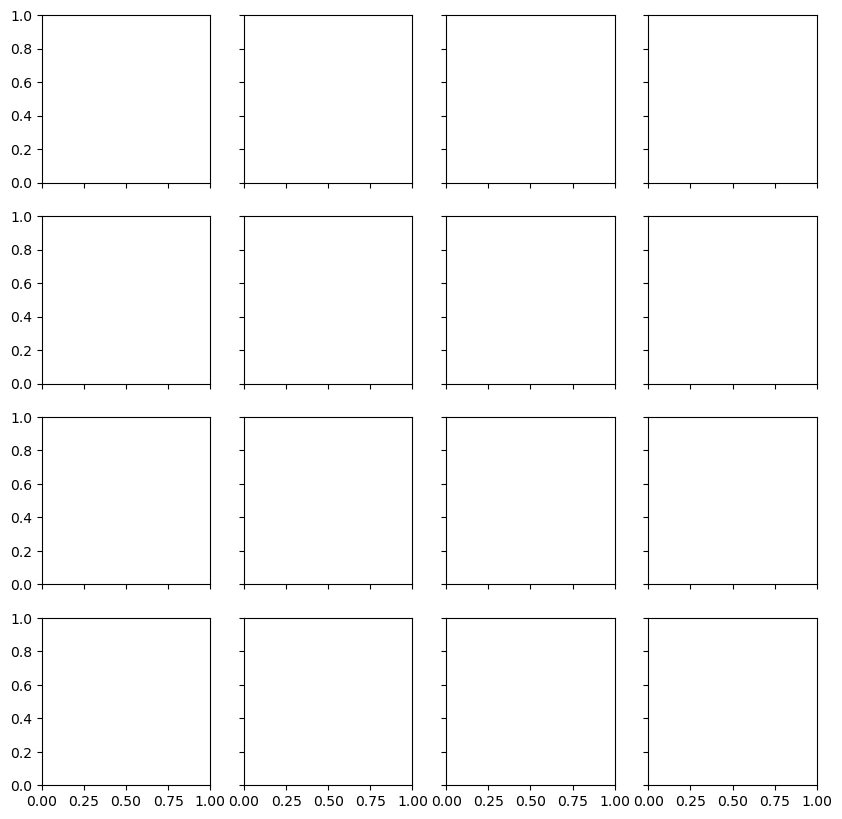

In [16]:
# plot_grid(unnormalize(cfg, x1))
plot_grid(x1.cpu())

In [76]:
x1_hat = model.encode_decode(x1)
x1_hat = x1_hat.detach().cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

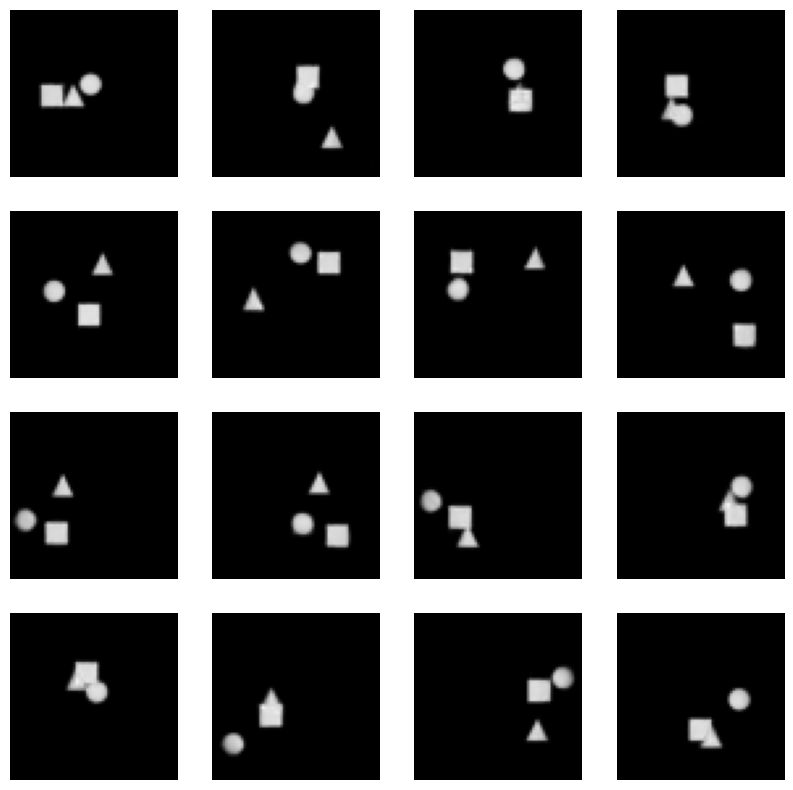

In [77]:
plot_grid(x1_hat)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


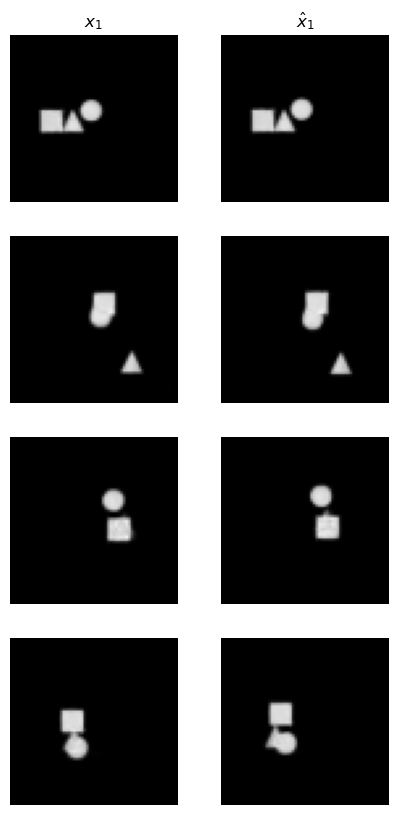

In [78]:
plot_rows([x1, x1_hat], col_labels=["$x_1$", "$\hat{x}_1$"], x_states=[x1], opacities=[0.3])

In [79]:
e1_hat = model.encode_to_noise(x1)
z1_hat = model.encode_to_causal(x1)

In [80]:
e1_hat.shape

torch.Size([64, 6])

TypeError: can't convert cuda:1 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

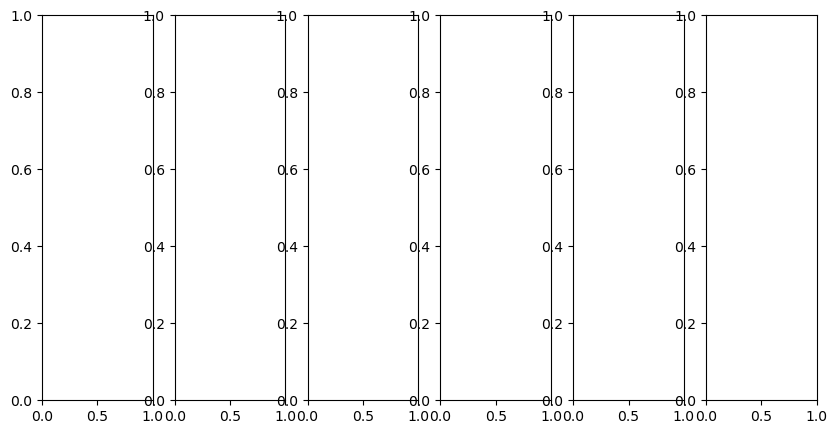

In [89]:
fig, axes = plt.subplots(figsize=(10, 5), ncols=z1.shape[1], nrows=1)

for i in range(z1.shape[1]):
    axes[i].hist(z1[:, i].detach().numpy(), bins=50, alpha=0.5, label="x1")
    axes[i].set_title(f"dim {i + 1}")

fig.suptitle("Histogram of $z_1$")

Text(0.5, 0.98, 'Histogram of $\\widehat{z_1}$')

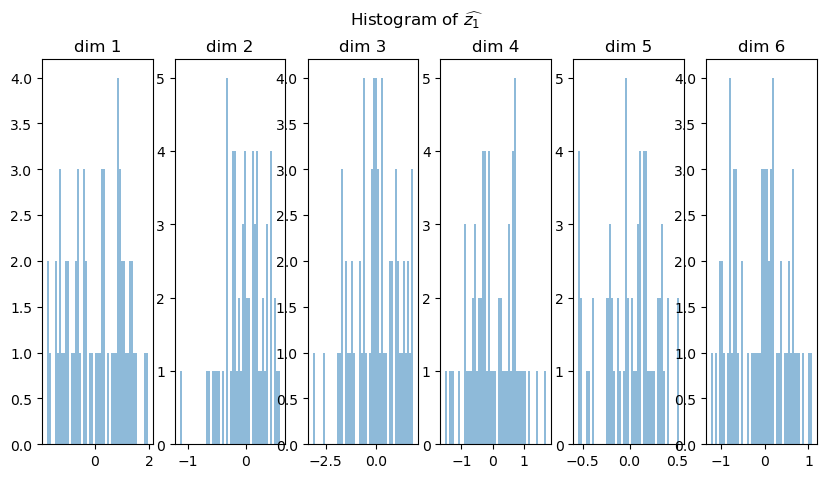

In [ ]:
fig, axes = plt.subplots(figsize=(10, 5), ncols=z1.shape[1], nrows=1)

for i in range(z1_hat.shape[1]):
    axes[i].hist(z1_hat[:, i].detach().numpy(), bins=50, alpha=0.5, label="x1")
    axes[i].set_title(f"dim {i + 1}")

fig.suptitle("Histogram of $\widehat{z_1}$")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

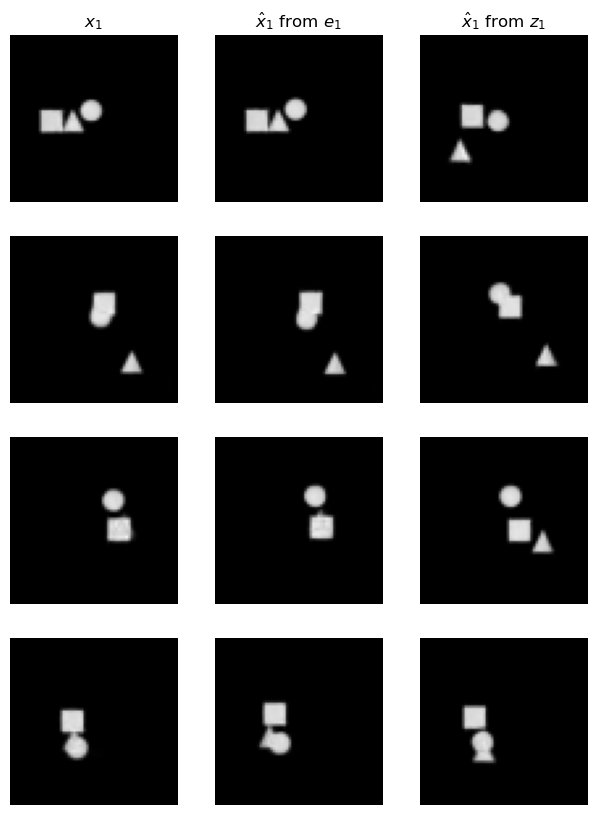

In [82]:
plot_rows(
    [
        x1,
        model.decode_noise(e1_hat).detach().cpu(),
        model.decode_causal(z1_hat).detach().cpu(),
    ],
    col_labels=["$x_1$", "$\hat{x}_1$ from $e_1$", "$\hat{x}_1$ from $z_1$"],
    x_states=[x1],
    opacities=[0.3],
)

## Interventions

Do interventions by overwriting adjacency matrix in `causal_to_noise`

In [83]:
def intervene(z, dim, mode="sample_uniform"):
    z_intervened = z.clone()
    if mode == "sample":
        mean = torch.mean(z[:, dim])
        std = torch.std(z[:, dim])
        delta = torch.randn_like(z[:, dim]) * std + mean
        z_intervened[:, dim] = delta
    if mode == "sample_uniform":
        zmin, zmax = torch.min(z[:, dim]), torch.max(z[:, dim])
        delta = torch.distributions.uniform.Uniform(zmin, zmax).sample(z[:, dim].shape)
        z_intervened[:, dim] = delta
    elif mode == "mean":
        z_intervened[:, dim] = torch.mean(z[:, dim])

    return z_intervened

### Intervene on $e$

In [84]:
# https://stackoverflow.com/a/59204638
def rotation_matrix_from_vectors(vec1, vec2):
    """Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s**2))
    return rotation_matrix


if data_type == "low_dim":
    R = rotation_matrix_from_vectors(x1[0], z1[0])
    R_inv = np.linalg.inv(R)

In [85]:
X1_hat_intervened = []

for dim in range(e1_hat.shape[1]):
    x1_hat_intervened = model.decode_causal(
        model.scm.noise_to_causal(intervene(e1_hat, dim=dim))
    ).detach()
    if data_type == "low_dim":
        x1_hat_intervened = x1_hat_intervened @ R_inv
    X1_hat_intervened.append(x1_hat_intervened)

TODO: test if both are equivalent

```
model.decode_causal(model.scm.noise_to_causal(intervene(e1_hat, dim=dim))).detach()
model.decode_causal(intervene(z1_hat, dim=dim)).detach()
```

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

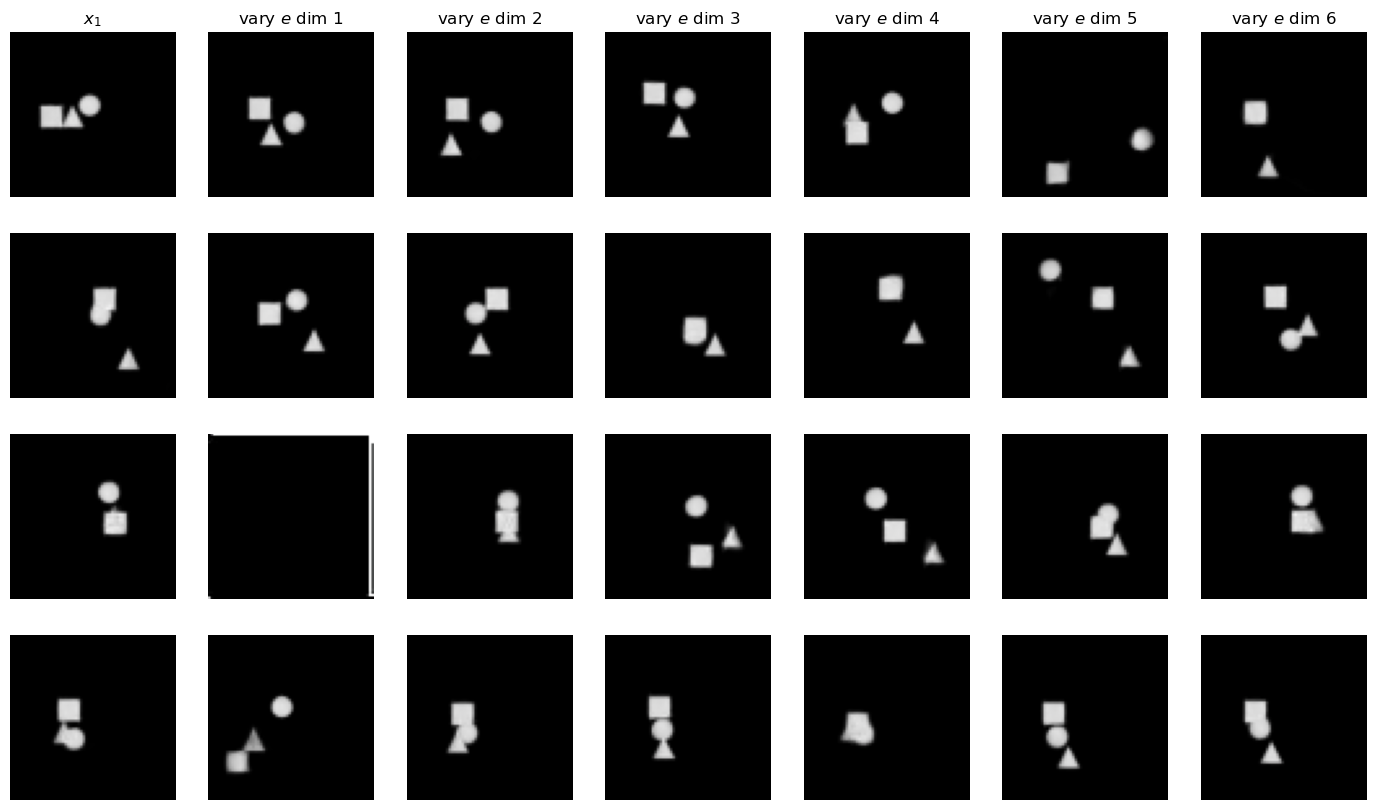

In [87]:
# Plot with ground truth counterfactuals

plot_rows(
    [x1_hat if data_type != "low_dim" else x1_hat @ R_inv, *X1_hat_intervened],
    col_labels=["$x_1$", *[f"vary $e$ dim {i}" for i in range(1, dim_z + 1)]],
    x_states=[x1_hat if data_type != "low_dim" else x1_hat @ R_inv],
    opacities=[0.3],
)

If we generated $x$ by rotating $z$, we can obtain the true $z$ by derotating $\widehat x$

In [ ]:
if data_type == "low_dim":
    x1_hat[0].detach(), z1_hat[0].detach(), z1[0].detach()

In [ ]:
if data_type == "low_dim":
    x1[0].detach() @ R_inv, z1[0].detach()

In [ ]:
if data_type == "low_dim":
    x1_hat[0].detach() @ R_inv, z1[0].detach()

### Intervene on $z$

In [90]:
X1_hat_intervened = []
E1_hat_intervened = []
for dim in range(e1_hat.shape[1]):
    e1_hat_z_intervention = model.scm.causal_to_noise(intervene(z1_hat, dim=dim))
    e1_intervened = e1_hat.clone()
    e1_intervened[:, dim] = e1_hat_z_intervention[:, dim]
    x1_hat_intervened = model.decode_noise(e1_intervened).detach()

    if data_type == "low_dim":
        x1_hat_intervened = x1_hat_intervened @ R_inv
    X1_hat_intervened.append(x1_hat_intervened.cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

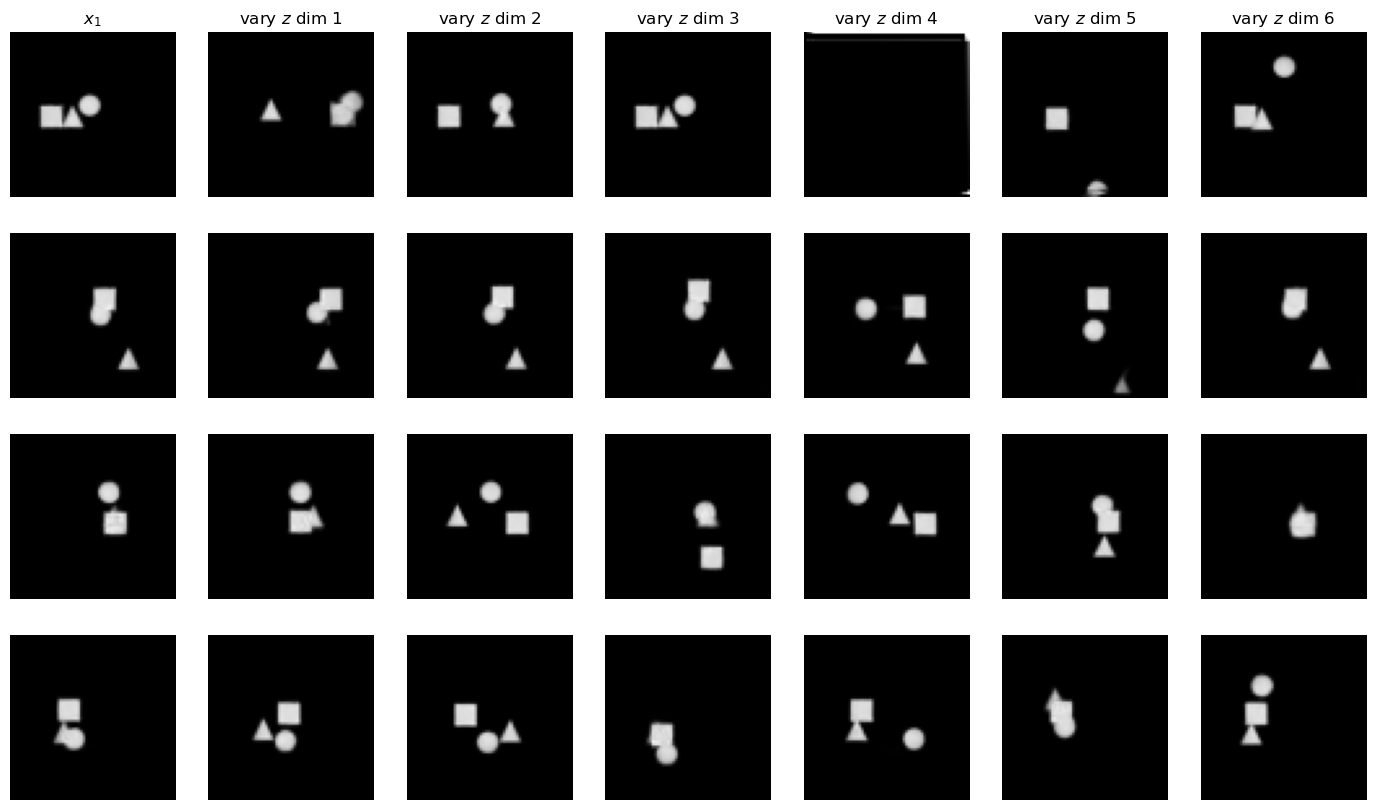

In [92]:
plot_rows(
    [x1_hat if data_type != "low_dim" else x1_hat @ R_inv, *X1_hat_intervened],
    col_labels=["$x_1$", *[f"vary $z$ dim {i}" for i in range(1, dim_z + 1)]],
    x_states=[x1_hat if data_type != "low_dim" else x1_hat @ R_inv],
    opacities=[0.3],
)

In [ ]:
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# randidx = np.random.randint(8000, 12000)
# ax[0].imshow(train_loader.dataset[randidx][0].permute(1, 2, 0))
# ax[1].imshow(train_loader.dataset[randidx][1].permute(1, 2, 0))

## Noise

In [ ]:
dl = get_dataloader(cfg, "train", batchsize=None, shuffle=False)

x1, x2, z1, z2, *_ = next(iter(dl))

In [ ]:
z_diff = z2 - z1

In [ ]:
z_diff.shape

torch.Size([10000, 6])

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
        0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
        0.77, 0.78, 0.79, 0.8 , 

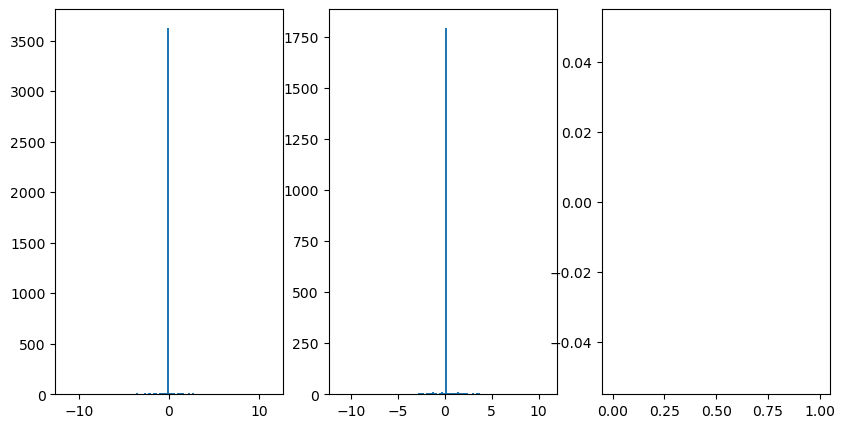

In [ ]:
fig, axes = plt.subplots(figsize=(10, 5), ncols=3)

axes[0].hist(z_diff[4000:8000, 0], bins=100)
axes[1].hist(z_diff[8000:12000, 1], bins=100)
axes[2].hist(z_diff[12000:16000, 2], bins=100)